In [20]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import arch
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Data Source: St. Louis Federal Reserve
#### Dataset: EUR/USD Daily Exchange Rate from 1991 to 2020

In [3]:
batch_size = 32

In [4]:
df = pd.read_csv('DEXUSEU.csv')

In [5]:
df.head()

,DATE,DEXUSEU
0,1999-01-04,1.1812
1,1999-01-05,1.1760
2,1999-01-06,1.1636
3,1999-01-07,1.1672
4,1999-01-08,1.1554


Only keep entries that contain numbers

In [6]:
df = df.loc[df['DEXUSEU'] != '.']

In [7]:
len(df)

5399

Compute the volatility with a 10-day rolling window, delete the first 10 entries as there is insufficient data for calculating their volatilities.

In [8]:
df['Vol'] = df.DEXUSEU.rolling(10).std()
df = df.loc[df.Vol > 0]
df['DATE'] = df['DATE'].apply(pd.to_datetime)
df['DEXUSEU'] = df['DEXUSEU'].astype(float)

### Visualise the Data

#### Histogram for Volatility

Text(0,0.5,'Frequency')

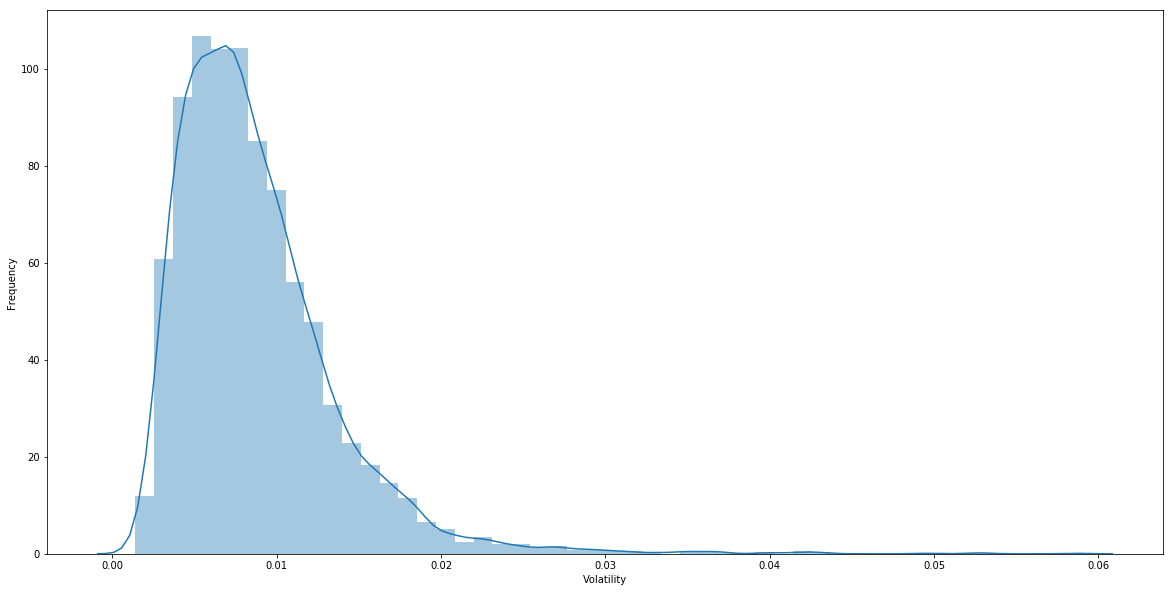

In [9]:
fig, ax = plt.subplots(figsize = (20, 10))
ax = sns.distplot(df.Vol)
ax.set_xlabel('Volatility')
ax.set_ylabel('Frequency')

#### Lineplot for Volatility

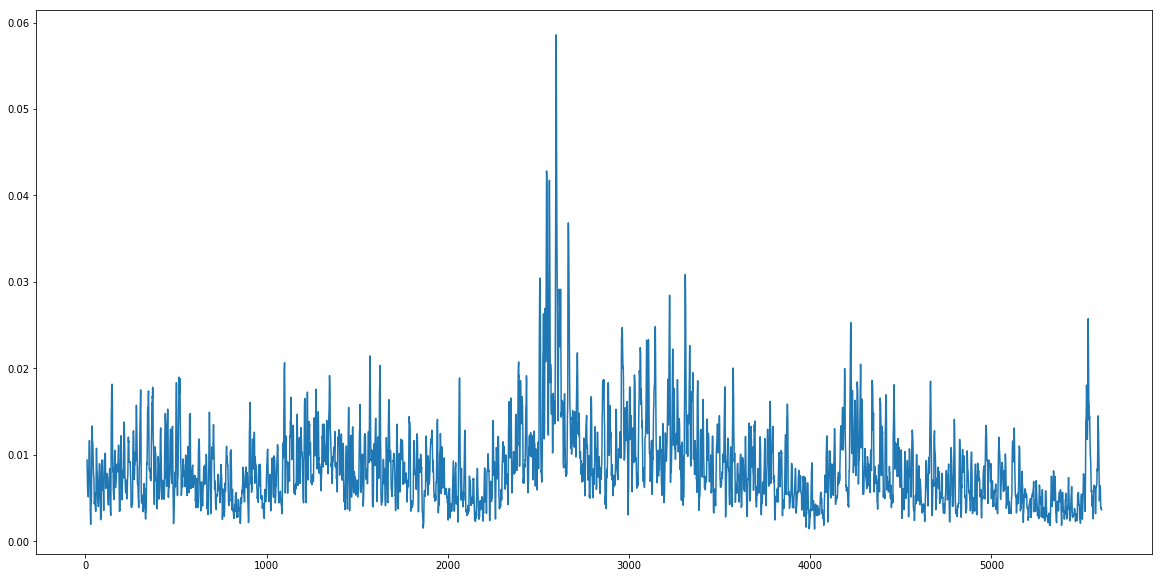

In [10]:
fig, ax = plt.subplots(figsize = (20, 10))
ax = sns.lineplot(data = df['Vol'])

#### Lineplot for Exchange Rates

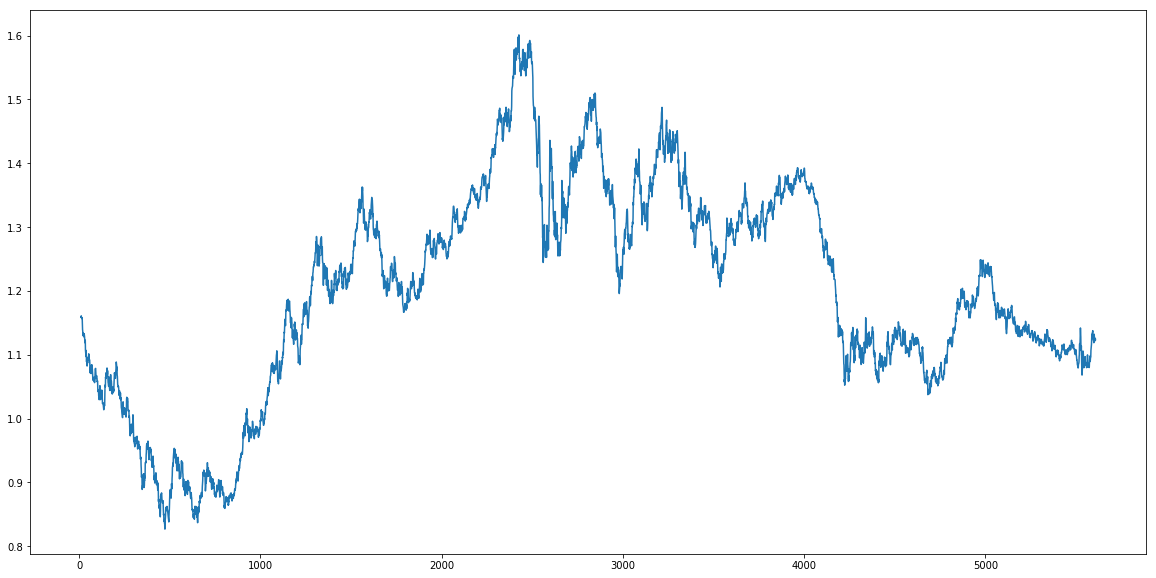

In [11]:
fig, ax = plt.subplots(figsize = (20, 10))
ax = sns.lineplot(data = df['DEXUSEU'])

Scale the dataset using Min-Max Scaler

In [12]:
scaler = MinMaxScaler()
scaler.fit(df['Vol'].astype(float).values.reshape(-1, 1))
df_scaled = scaler.transform(df['Vol'].astype(float).values.reshape(-1, 1))

Split the dataset into training and test datasets, ensure that the sizes are divisible by batch size 64

In [13]:
df_train, df_test = df_scaled[0:4860], df_scaled[4860 : -1]

In [14]:
timesteps = 30
length = len(df_train) - 2 * timesteps
X_train = []
y_train = []
for i in range(timesteps, length + timesteps):
    X_train.append(df_train[i - timesteps: i])
    y_train.append(df_train[i : i + timesteps])
print(len(X_train))
print(len(y_train))

4800
4800


In [15]:
X_test = []
y_test = []
length = len(df_test) - 2 * timesteps

for i in range(timesteps, length + timesteps):
    X_test.append(df_test[i - timesteps: i])
    y_test.append(df_test[i : i + timesteps])
    
X_test = X_test[0: 448]
y_test = y_test[0: 448]
print(len(X_test))
print(len(y_test))

448
448


In [16]:
X_train = np.concatenate(X_train).reshape((len(X_train), timesteps, 1))
y_train = np.concatenate(y_train).reshape((len(y_train), timesteps, 1))
X_test = np.concatenate(X_test).reshape((len(X_test), timesteps, 1))
y_test = np.concatenate(y_test).reshape((len(y_test), timesteps, 1))

### Autoregressive Model

c:\users\zewen feng\appdata\local\programs\python\python36\lib\site-packages\matplotlib\pyplot.py:962: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  return gcf().gca(**kwargs)


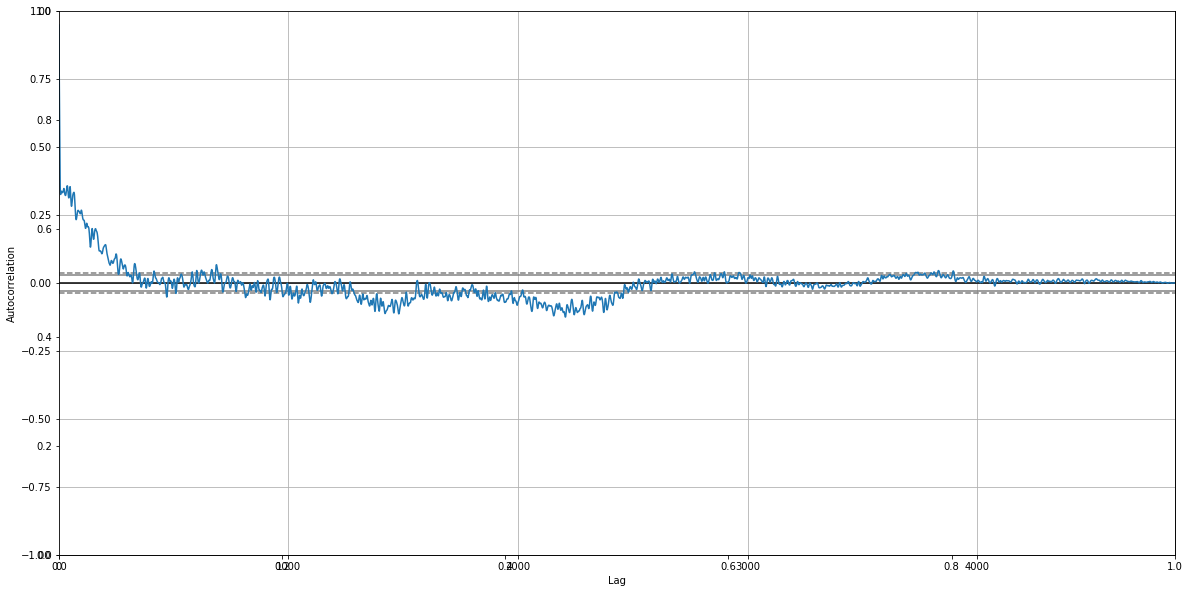

In [27]:
fig, ax = plt.subplots(figsize = (20, 10))
ax = autocorrelation_plot(df_train)

In [28]:
model = arch.arch_model(df_train, mean='Zero', vol='GARCH', p=1, q=1)
model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3039.151264092487
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3039.151291293592
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1


c:\users\zewen feng\appdata\local\programs\python\python36\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007287. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
c:\users\zewen feng\appdata\local\programs\python\python36\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3039.15
Distribution:                  Normal   AIC:                          -6072.30
Method:            Maximum Likelihood   BIC:                          -6052.84
                                        No. Observations:                 4860
Date:                Fri, Jul 10 2020   Df Residuals:                     4857
Time:                        22:26:34   Df Model:                            3
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.0502e-04  7.900e-05      6.392  1.632e-10 [3.

### LSTM Model

In [19]:
inputs_mae = Input(batch_shape = (batch_size, timesteps , 1))
lstm1_mae = LSTM(30, stateful = True, return_sequences = True)(inputs_mae)
lstm2_mae = LSTM(30, stateful = True, return_sequences = True)(lstm1_mae)
output_mae = Dense(1)(lstm2_mae)
regressor_mae = Model(inputs = inputs_mae, outputs = output_mae)
regressor_mae.compile(optimizer = 'adam', loss = 'mae')
regressor_mae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 30, 1)]             0         
_________________________________________________________________
lstm_2 (LSTM)                (32, 30, 30)              3840      
_________________________________________________________________
lstm_3 (LSTM)                (32, 30, 30)              7320      
_________________________________________________________________
dense_1 (Dense)              (32, 30, 1)               31        
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [20]:
num_epochs = 10
for i in range(num_epochs):
    regressor_mae.fit(X_train, y_train, batch_size = batch_size, epochs = 1, shuffle = False)
    regressor_mae.reset_states()

150/150 [==============================] - 3s 19ms/step - loss: 0.0572


In [21]:
regressor_mae.evaluate(X_test[0:448], y_test[0:448], verbose = 0)

0.04599004611372948

In [24]:
inputs_mse = Input(batch_shape = (batch_size, timesteps , 1))
lstm1_mse = LSTM(30, stateful = True, return_sequences = True)(inputs_mse)
lstm2_mse = LSTM(30, stateful = True, return_sequences = True)(lstm1_mse)
output_mse = Dense(1)(lstm2_mse)
regressor_mse = Model(inputs = inputs_mse, outputs = output_mse)
regressor_mse.compile(optimizer = 'adam', loss = 'mse')
regressor_mse.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(32, 30, 1)]             0         
_________________________________________________________________
lstm_6 (LSTM)                (32, 30, 30)              3840      
_________________________________________________________________
lstm_7 (LSTM)                (32, 30, 30)              7320      
_________________________________________________________________
dense_3 (Dense)              (32, 30, 1)               31        
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [25]:
num_epochs = 10
for i in range(num_epochs):
    regressor_mse.fit(X_train, y_train, batch_size = batch_size, epochs = 1, shuffle = False)
    regressor_mse.reset_states()
    

150/150 [==============================] - 3s 19ms/step - loss: 0.0065


In [26]:
regressor_mse.evaluate(X_test, y_test, verbose = 0)

0.0042412420734763145

In [ ]:
regressor_mse.predict(X_test[0:448])